In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')

In [49]:
data = pd.read_csv('lausanne_marathon_2016.csv')
data.head()

,Unnamed: 0,cat,sex,rang,nom,an,lieu,temps,retard,pace
0,0,21,M,147,Abaidia Jilani,1966,St-Légier-La Chiésaz,"1:45.28,4","25.56,8",4.59
1,1,21,F,81,Abaidia Sandrine,1972,St-Légier,"1:49.40,8","24.09,5",5.11
2,2,False,F,33,Abaidia Selma,2006,St-Légier-La Chiésaz,"7.12,2","1.36,3",4.48
3,3,21,M,103,Abb Jochen,1948,Ernen,"2:50.40,7","1:21.28,7",8.05
4,4,10,M,426,Abbas Dhia,1961,Lausanne,"1:13.04,1","38.13,0",7.18


## Stats on age

**Ideas**:
- statistical tests for men and women age over time:
    1. variance analysis (F test in normal case)
    2. mean analysis (T-test/ Welch test)
    3. plot with p-value and some critical thresholds (0.2,0.1,0.05,0.01)
- interactive plot of age distribution over time for men and women

Take a look at the age distribution of the whole population:

In [4]:
age = 2016-data.an.astype(int)

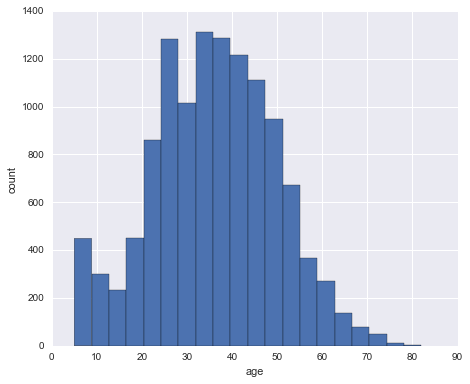

In [5]:
# get age of participants and plot its distribution
plt.subplot(1,2,1)
plt.hist(age,bins=20)
plt.gca().set_xlabel('age')
plt.gca().set_ylabel('count')
plt.gcf().set_size_inches(16,6)

Now compare the age distribution for women and men:

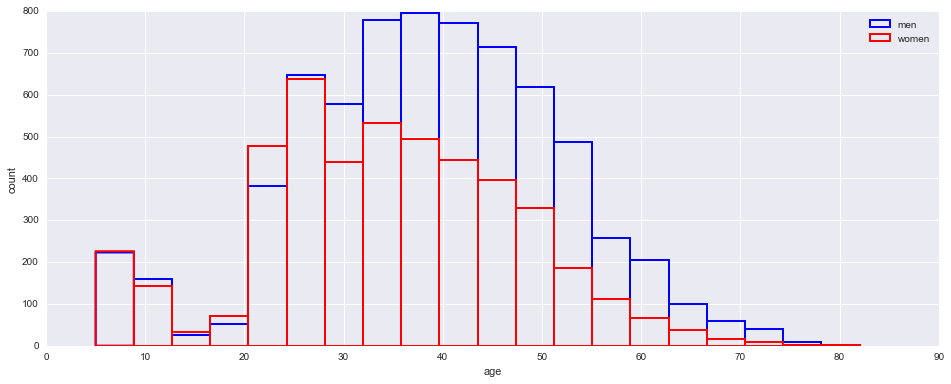

In [6]:
age_women = 2016 - data[data.sex=='F'].an.astype(int)
age_men = 2016 - data[data.sex=='M'].an.astype(int)
plt.hist(age_men,edgecolor='blue',fill=False,linewidth=2,label='men',bins=20)
plt.hist(age_women,edgecolor='red',fill=False,linewidth=2,label='women',bins=20)
plt.xlabel('age')
plt.ylabel('count')
plt.gca().set_xlim([0,90])
plt.gcf().set_size_inches(16,6)
plt.legend()

Clean data from 'False' (walk, kids running):

In [7]:
del data['Unnamed: 0']
data = data[data.cat != 'False']

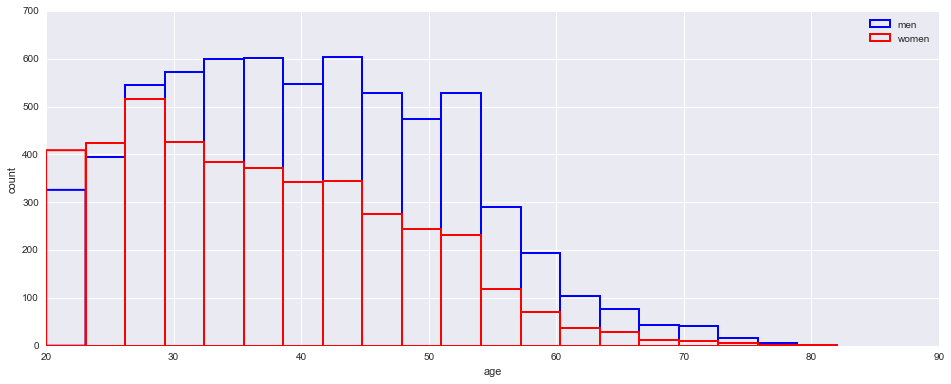

In [8]:
age_women = 2016 - data[data.sex=='F'].an.astype(int)
age_men = 2016 - data[data.sex=='M'].an.astype(int)
plt.hist(age_men,edgecolor='blue',fill=False,linewidth=2,label='men',bins=20)
plt.hist(age_women,edgecolor='red',fill=False,linewidth=2,label='women',bins=20)
plt.xlabel('age')
plt.ylabel('count')
plt.gca().set_xlim([20,90])
plt.gcf().set_size_inches(16,6)
plt.legend()

Sex-based statistical tests by category:

In [9]:
from scipy import stats
ks_stats = []
ks_pvalues = []
kw_stats = []
kw_pvalues = []
kstest = stats.ks_2samp(2016-data[data.sex=='M'].an.astype(int),2016-data[data.sex=='F'].an.astype(int))
ks_stats.append(kstest[0])
ks_pvalues.append(kstest[1])
kwtest = stats.mstats.kruskalwallis(2016-data[data.sex=='M'].an.astype(int),2016-data[data.sex=='F'].an.astype(int))
kw_stats.append(kwtest[0])
kw_pvalues.append(kwtest[1])

for i in ['10','21','42']:
    subdata = data[data.cat==i]
    kstest = stats.ks_2samp(2016-subdata[subdata.sex=='M'].an.astype(int),2016-subdata[subdata.sex=='F'].an.astype(int))
    ks_stats.append(kstest[0])
    ks_pvalues.append(kstest[1])
    kwtest = stats.mstats.kruskalwallis(2016-subdata[subdata.sex=='M'].an.astype(int),2016-subdata[subdata.sex=='F'].an.astype(int))
    kw_stats.append(kwtest[0])
    kw_pvalues.append(kwtest[1])

test = {'KS stat' : pd.Series(ks_stats), 'KS p-value' : pd.Series(ks_pvalues), 'category' : pd.Series(['global','10','21','42']), 'KW stat' : pd.Series(kw_stats), 'KW p-value' : pd.Series(kw_pvalues)}
test_result = pd.DataFrame(test)
test_result = test_result.set_index('category')
test_result

,KS p-value,KS stat,KW p-value,KW stat
category,,,,
global,1.010906e-40,0.134037,6.411120e-62,275.726303
10,3.487088e-23,0.142575,3.143475e-35,153.392881
21,2.448399e-08,0.096879,1.339886e-11,45.755268
42,8.376947e-04,0.144672,6.268202e-05,16.019844


In [10]:
data.lieu.value_counts().index

Index(['Lausanne', 'Genève', 'Pully', 'Epalinges', 'Morges', 'Vevey', 'Zürich',
       'Le Mont-sur-Lausanne', 'Nyon', 'Ecublens VD',
       ...
       'Bonaduz', 'F-Villemomble', 'B-Neupré', 'F-Eysines', 'F-Carrouge VD',
       'I-Canegrate (MI)', 'F-Cuvat', 'F-Jonzier Epagny', 'F-Metz',
       'Rehetobel'],
      dtype='object', length=1990)

In [42]:
# get the list of Swiss cities from Wikipedia and parse their population

import requests
r = requests.get('https://en.wikipedia.org/wiki/List_of_cities_in_Switzerland')
pop = pd.read_html(r.text)
pop = pop[2]
pop = list(pop[4])
pop = pop[2:len(pop)]

def clearString(string):
    nans = [' ',',','?']
    newstring = []
    k = 0
    while (k < len(string)):
        if((string[k] in nans)==False):
            newstring.append(string[k])
        k = k+1
    newstring = ''.join(newstring)
    return newstring

population = []
for city in pop:
    population.append(int((clearString(city))))

Plot the distribution of the Swiss cities population:

C:\Users\Utente\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


[None, None]

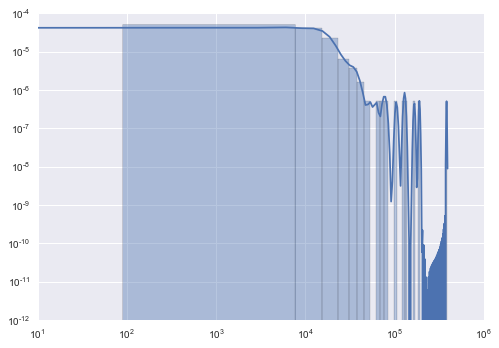

In [48]:
ax = sns.distplot(population)
ax.set(xscale='log',yscale='log')

**Observations**:
- number of corridors per city: it can be *scale-invariant*, assuming that the sport attitude is uniform across the population; a **power law** can then be compatible with this hypothesis;
- population of Swiss cities: it does not follow a power law on the whole range; maybe there is a scaling-invariant trend for populations between 1e4 and ~8e4. 

Let us have a look at the number of runners coming from each Swiss city in the dataset. We observe that:
- **Lausanne** has a population of 129902 citizens and has born 2043 runners (ratio: 1.5%);
- **Zurich** has a population of 378884 citizens and has born only 133 runners (ratio: 0.035%), just above **Mont-sur-Lausanne** (129 runners out of 5347).
The distribution of the runners across the cities is then not trivially related to the Swiss cities population's, because otherwise there would be some proportionality. Probably the other factor which comes into play is the ***distance*** of the runner's origin city from the place where the competition takes place (indeed Zurich is much more far away from Lausanne than for example Pully of Vevey, which are much less populated). One could try to suppose a sort of **gravitational relationship**, where the number of runners from each city is the 'product' of the *mass* (populations) and the *inverse squared distance*, up to a universal multiplicative constant $\gamma$:
$$N_{runners} \sim \gamma \frac{P_{origin}P_{place}}{d^2}$$
See for instance [this page](https://en.wikipedia.org/wiki/Demographic_gravitation).

Moreover, the population distribution does not seem scaling-invariant. This is because the demographical processes may lead to the formation of bigger clusters which break the proportionality rule. According to a power law $X~P(\lambda)$, we would have indeed:

$$P_1 = P(k < x < k+\delta)=k^{1-\lambda}-(k+\delta)^{1-\lambda}$$

$$P_M = P(Mk < x < M(k+\delta))=M^{1-\lambda}[k^{1-\lambda}-(k+\delta)^{1-\lambda}]$$

$$\frac{P_M}{P_1}=M^{1-\lambda}$$

If one takes a look at the population distribution across cities, some problems arise for very high values of population, because there are some outliers (big urban conglomerations) which do not follow the decay factor prescribed by a power law, much more than what a simple random disturbance could generate. One could try to apply a power law only in a certain population range.

In [62]:
133/378884

0.0003510309223931335

In [60]:
data.lieu.value_counts()

Lausanne                 2043
Genève                    503
Pully                     312
Epalinges                 184
Morges                    156
Vevey                     139
Zürich                    133
Le Mont-sur-Lausanne      129
Ecublens VD               121
Nyon                      116
Lutry                     107
Renens VD                 105
La Tour-de-Peilz           93
Bern                       88
Yverdon-les-Bains          84
Bussigny                   82
Fribourg                   82
Prilly                     77
Crissier                   76
Neuchâtel                  74
Cheseaux-sur-Lausanne      72
Préverenges                66
Gland                      60
Echallens                  59
St-Légier                  57
St-Sulpice VD              56
Chavannes-près-Renens      56
St-Prex                    54
F-Paris                    54
Leysin                     53
                         ... 
F-Cognin                    1
Vers chez les blancs        1
I-Parma (P

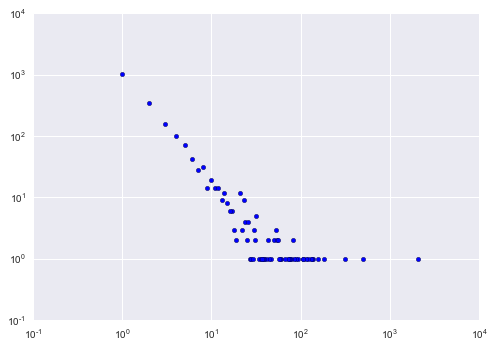

In [59]:
x = data.lieu.value_counts().value_counts().index
y = data.lieu.value_counts().value_counts()[x]
plt.scatter(x,y)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')